In [1]:
%matplotlib inline

In [516]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
import torch
from scipy import signal, ndimage, spatial
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 
from signal_alignment import phase_align, chisqr_align
from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy.stats import spearmanr

### Function Definitions 

In [3]:
def cleaning_wave_df(DF):
    # dropping columns with no value
    #DF = DF.dropna(axis =1) 
    # dropping wave id column
    DF = DF.drop(columns = 2, axis =1)
    # name the first sensor columns 
    cols_0={0: "Time", 1: "FrameID", 3: "SensorID", 4: "Sensor_1Status", 5: "X_Nose", 6: "Y_Nose", 7:"Z_Nose"}
    DF = DF.rename(columns=cols_0, errors="raise")
    DF = DF.drop(columns = [8,9,10, 11], axis =1)
    
    DF = DF.drop(columns = [12,13,14,15,16,17,18,19,20], axis =1)
    cols_1={21: "SensorID", 22: "Sensor_2Status", 23: "X_LLeft", 24: "Y_LLeft", 25:"Z_LLeft"}
    DF = DF.rename(columns=cols_1, errors="raise")
    
    DF = DF.drop(columns = [26,27,28,29], axis =1)
    cols_2={30: "SensorID", 31: "Sensor_3Status", 32: "X_LR", 33: "Y_LR", 34:"Z_LR"}
    DF = DF.rename(columns=cols_2, errors="raise")
    
    DF = DF.drop(columns = [35,36,37,38], axis =1)
    cols_3={39: "SensorID", 40: "Sensor_4Status", 41: "X_UL", 42: "Y_UL", 43:"Z_UL"}
    DF = DF.rename(columns=cols_3, errors="raise")
    
    DF = DF.drop(columns = [44,45,46,47], axis =1)
    cols_4={48: "SensorID", 49: "Sensor_5Status", 50: "X_LL", 51: "Y_LL", 52:"Z_LL"}
    DF = DF.rename(columns=cols_4, errors="raise")
    
    DF = DF.drop(columns = [53,54,55,56], axis =1)
    cols_5={57: "SensorID", 58: "Sensor_6Status", 59: "X_JR", 60: "Y_JR", 61:"Z_JR"}
    DF = DF.rename(columns=cols_5, errors="raise")
    
    DF = DF.drop(columns = [62,63,64,65], axis =1)
    cols_6={66: "SensorID", 67: "Senson_7Status", 68: "X_JL", 69: "Y_JL", 70:"Z_JL"}
    DF = DF.rename(columns=cols_6, errors="raise")
    DF = DF.drop(columns = [71,72,73,74], axis =1)
    return DF

# cleaning video data 

def cleaning_video_df(DF):
    
    # choose the needed columns and convert the values to mm
    DF = DF[["BAG_Frame_number",'Time_Stamp (s)','Video_Frame_number',
             'landmark_48', 'landmark_48.1', 'landmark_48.2', 'landmark_54',
            'landmark_54.1', 'landmark_54.2', 'landmark_51', 'landmark_51.1',
            'landmark_51.2', 'landmark_57', 'landmark_57.1', 'landmark_57.2']]
  
    
    DF = DF.rename(columns={'Time_Stamp (s)': 'Time', "landmark_48": "X_LR", "landmark_48.1": "Y_LR",
                           "landmark_48.2": "Z_LR", "landmark_54": "X_LLeft",
                           "landmark_54.1": "Y_LLeft", "landmark_54.2": "Z_LLeft",
                           "landmark_51": "X_UL", "landmark_51.1": "Y_UL",
                           "landmark_51.2": "Z_UL", "landmark_57": "X_LL", "landmark_57.1": "Y_LL",
                           "landmark_57.2": "Z_LL"})
    
    DF = DF.astype({ "X_LR": np.double, "Y_LR": np.double,"Z_LR": np.double, "X_LLeft": np.double,
                            "Y_LLeft": np.double, "Z_LLeft": np.double, "X_UL": np.double,  "Y_UL": np.double,
                            "Z_UL": np.double,  "X_LL": np.double,  "Y_LL": np.double, "Z_LL": np.double})
    
    # conver the values from m to mm
    DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]] =  DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]]*1000
    return DF

def area_of_triangle(A,B,C):

    """
    computes the area of a triangle given by 3 points in 2d or 3d

    A, B and C must be numpy arrays

    it works with vectors A=[a1,a2,a3], B=[b1,b2,b3], c=[c1,c2,c3] or matrices

    A=[[a11,a12,a13],...[a1n,a2n,b3n]], B=[[b11,b12,b13],...[b1n,b2n,b3n]], C=[[c11,c12,c13],...[c1n,c2n,c3n]]

    """

    As = A.shape
    Bs = B.shape
    Cs = C.shape
   
    if len(As) == 1 :

        #we got vectors

        if (As[0]>3) or (Bs[0]>3) or (Cs[0]>3):

            raise Exception('coordinates can only be 2d or 3d')

            return None

    else:

        #check at least one of the dimensions is two or three
        if (As[0]==2) or (As[0]==3) or (As[1]==2) or (As[1]==3):

            #one of the dimensions of A is 2 or 3, now check that all the vectors have the same size
            if (As!=Bs) or (As!=Cs):

                raise Exception('vectors must be the same size')
                return None

            else:
                #move forward
                pass

        else:

            raise Exception('coordinates can only be 2d or 3d')

            return None

    #at this point we know that one of the dimensions has 2 or 3 elements we move forward assuming that
    #the user provided the vectors with the correct size
    #move all vectors to the same origin

    AB = B-A
    AC = C-A  

    if len(As) == 1 :

        #if only one vector the simply compute the norm of the cross product
        area = (1/2)*np.linalg.norm(np.cross(AB,AC))

    else:

        #if only multiple vectors compute the norm along the axis one
        area = (1/2)*np.linalg.norm(np.cross(AB,AC), axis = 1)   

    return area

def lipDist(DF):
    
    # Assumes columns are named in a particular way 
    
    DF['Horiz_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_LLeft - row.X_LR)**2 + (row.Y_LLeft - row.Y_LR)**2
                                                                  + (row.Z_LLeft - row.Z_LR)**2), axis = 1) 
    DF['Vert_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_UL - row.X_LL)**2 + (row.Y_UL - row.Y_LL)**2 +
                                                                 (row.Z_UL - row.Z_LL)**2), axis = 1)
    return DF

def rom(list_of_arrays):

    
    reps_max_values = np.array([np.max(array) for array in list_of_arrays])
    reps_min_values = np.array([np.min(array) for array in list_of_arrays])
    
    
    ROM = reps_max_values - reps_min_values
    
    return ROM

In [4]:
# Signal Processing

# sampling frequency set to 100 HZ
fsample = 100

def sig_shift(signal, amount):
    length = len(signal)    
    shifted = np.zeros(length+amount - 1)
    shifted[:amount-1] = 0
    shifted[amount-1:] = signal[:]
    return shifted

def sig_norm(signal):
    signal_mean = np.mean(signal)
    signal_normalised = signal - signal_mean
    return signal_normalised

# Butterworth filter 8-order, 15hz cutoff
fc = 15
w = fc / (fsample/2)
b , a = signal.butter(8, w, btype ='lowpass')

### Reading, Cleaning, and Preprocessing DATA

In [5]:
Tasks = ['REST', 'OPEN', 'SPREAD', 'OOEE', 'PA', 'BBP', 'TNG_PROTRUSION', 'TNG_LAT', 'TNG_NOSE']
Conditions = ['FAST', 'SLOW', 'DIS', 'HOLD', 'NORMAL']

TASK_DFS_VIDEO_LIST = list()
TASK_DFS_WAVE_LIST = list()

In [6]:
# choose a task to do the analysis on,for example open, spread, pa, bbp, etc
Task = Tasks[5]

In [7]:
#####   WAVE DATA   ######

# read the wave data files of the chosen task into dfs and store them all in a list 
path_w = r'C:\Users\jafarid\Documents\Code\ValidationStudy\wave_data'
ext_w=('.tsv')
Files_w = os.listdir(path_w)           
Files_w = [i for i in Files_w if i.endswith(ext_w)]

for i in range(0, len(Files_w)):
    # choose which task to focus on 
    if Task in Files_w[i]:
        df = pd.read_csv(path_w+ "\\" + Files_w[i], delimiter='\t', skiprows=1,header=None)
        df = cleaning_wave_df(df)
        # depending on the file we are reading the indexing below needs to change 
        #if Files_w[i][20:-4] == 'EN_HOLD_1' or Files_w[i][20:-4] == 'EN_HOLD':
        #    df['FileName'] = Files_w[i][18:-4]
        
        #else: 
        df['FileName'] = Files_w[i][18:-4]
        df['PatientID'] = Files_w[i][:2]
       # df['DataDATE'] = Files_w[i][5:13]
        df['Task'] = Task
        for condition in Conditions:
            if condition in Files_w[i]:
                df['Condition'] = condition

            else:
                df['Condition'] = 'NORM'
                
   
        # preprocessing, using the cubic interpolation to fill in the missing data 
        df = df.interpolate(method ='cubic', limit_direction ='forward') 
        df = lipDist(df)

        # Displacements
         # Butterworth filter 8-order, 15hz cutoff
        df['Vert_Lip_Motion_F1']= signal.filtfilt(b, a, df['Vert_Lip_Motion'])
        df['Horiz_Lip_Motion_F1'] = signal.filtfilt(b, a, df['Horiz_Lip_Motion'])
        # velocity 
        df["Speed"] = np.gradient(df['Vert_Lip_Motion'], df["Time"])
        
        #left_area = area_of_triangle(df[["X_LLeft", "Y_LLeft", "Z_LLeft"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
        #                               df[["X_LL", "Y_LL", "Z_LL"]].values)
        #df['Area_Left'] = np.array(left_area)
        #right_area = area_of_triangle(df[["X_LR", "Y_LR","Z_LR"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
        #                                df[[ "X_LL", "Y_LL", "Z_LL"]].values)
        #df['Area_Right'] =  np.array(right_area)        
        #df["Area_Ratio"] = df.apply(lambda row: row.Area_Left/row.Area_Right, axis = 1)
        
        # Gaussian filter
        #df['Vert_Lip_Motion_F1']= gaussian_filter(df['Vert_Lip_Motion'], sigma=7)
        #df['Horiz_Lip_Motion_F1']= gaussian_filter(df['Horiz_Lip_Motion'], sigma=7)
        #df["Speed_F1"] = gaussian_filter(np.gradient(df['Vert_Lip_Motion'], df["Time"]), 3)
        
        
        TASK_DFS_WAVE_LIST.append(df)        
        print(Files_w[i][:2],Files_w[i][18:-4])


DJ BBP_NORMAL
DJ BBP_SLOW
MK BBP_NORMAL
MK BBP_SLOW
RM BBP_NORMAL
RM BBP_SLOW


In [8]:
if 0:
    %matplotlib qt
    plt.plot(TASK_DFS_WAVE_LIST[3]['Vert_Lip_Motion'],'b')
    plt.plot(TASK_DFS_WAVE_LIST[3]['Vert_Lip_Motion_F1'],'g')
    plt.plot(TASK_DFS_WAVE_LIST[3]['Vert_Lip_Motion_F2'],'r')

In [9]:
#####   VIDEO DATA   ######

# read the wave data files of the chosen task into dfs and store them all in a list 
path_v = r'C:\Users\jafarid\Documents\Code\ValidationStudy\video_data_processed'
ext_v=('_Landmarks3D.csv')
Files_v = os.listdir(path_v)           
Files_v = [i for i in Files_v if i.endswith(ext_v)]

for i in range(0, len(Files_v)):
    # choose which task to focus on 
    if Task in Files_v[i]:
        df = pd.read_csv(path_v+ "\\" + Files_v[i])
        df =  df.drop([0]) 
        df = cleaning_video_df(df)
        # depending on the file we are reading the indexing below needs to change 
        df['FileName'] = Files_v[i][8:-16]
        df['PatientID'] = Files_v[i][:2]
       # df['DataDATE'] = Files_v[i][5:13]
        df['Task'] = Task
        for condition in Conditions:
            if condition in Files_v[i]:
                df['Condition'] = condition

            else:
                df['Condition'] = 'NORM'
                

        # preprocessing, using the cubic interpolation to fill in the missing data 
        df = df.interpolate(method ='cubic', limit_direction ='forward') 
        df = lipDist(df)
        
        # AREA
        #left_area = area_of_triangle(df[["X_LLeft", "Y_LLeft", "Z_LLeft"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
        #                               df[["X_LL", "Y_LL", "Z_LL"]].values)
        #df['Area_Left'] = np.array(left_area)
        #right_area = area_of_triangle(df[["X_LR", "Y_LR","Z_LR"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
        #                                df[[ "X_LL", "Y_LL", "Z_LL"]].values)
        #df['Area_Right'] =  np.array(right_area)        
        #df["Area_Ratio"] = df.apply(lambda row: row.Area_Left/row.Area_Right, axis = 1)
        
        
        #df['Vert_Lip_Motion_F1']= gaussian_filter(df['Vert_Lip_Motion'], sigma=3)
        #df['Horiz_Lip_Motion_F1']= gaussian_filter(df['Horiz_Lip_Motion'], sigma=3)
        #df["Speed_F1"] = gaussian_filter(np.gradient(df['Vert_Lip_Motion_F1'], df["Time"]), 3)
        
        # DISPLACEMENT
         # Butterworth filter 8-order, 15hz cutoff
        df['Vert_Lip_Motion_F1']= signal.filtfilt(b, a, df['Vert_Lip_Motion'])
        df['Horiz_Lip_Motion_F1'] = signal.filtfilt(b, a, df['Horiz_Lip_Motion'])
        # velocity 
        df["Speed"] = np.gradient(df['Vert_Lip_Motion'], df["Time"])
        TASK_DFS_VIDEO_LIST.append(df)
        print(Files_v[i][:2], Files_v[i][8:-16])

    


DJ BBP_NORMAL
DJ BBP_SLOW
MK BBP_NORMAL
MK BBP_SLOW
RM BBP_NORMAL
RM BBP_SLOW


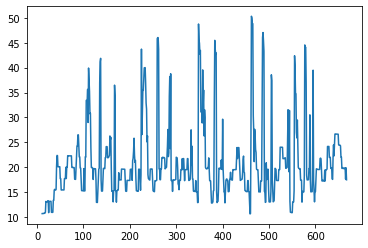

In [10]:
plt.plot(TASK_DFS_VIDEO_LIST[3][10:]['Vert_Lip_Motion'])
#plt.plot(TASK_DFS_WAVE_100HZ_LIST[3]['Vert_Lip_Motion'])

In [11]:

TASK_DFS_WAVE_100HZ_LIST = list()


In [12]:
# RESAMPLING TO 100Hz for the wave data

for DF_WAVE in TASK_DFS_WAVE_LIST:
    WAVE_100HZ = pd.DataFrame()
    tmax = len(DF_WAVE.Time) - 1
    tmax_value = DF_WAVE.Time[tmax]
    tmin_value = DF_WAVE.Time[0]
    nsample = fsample*(tmax_value - tmin_value)
    perfect_time = np.linspace(tmin_value, tmax_value, num= nsample, endpoint=True)
    WAVE_100HZ['Time'] = perfect_time
    f_motion = interp1d(DF_WAVE.Time, DF_WAVE['Vert_Lip_Motion_F1'], kind = 'linear')
    WAVE_100HZ['Vert_Lip_Motion'] = f_motion(perfect_time)
    f_motion2 = interp1d(DF_WAVE.Time, DF_WAVE['Horiz_Lip_Motion_F1'], kind = 'linear')
    WAVE_100HZ['Horiz_Lip_Motion'] = f_motion2(perfect_time)
    f_speed = interp1d(DF_WAVE.Time, DF_WAVE['Speed'], kind = 'linear')
    WAVE_100HZ['Speed'] = f_speed(perfect_time)
    WAVE_100HZ['FileName'] = DF_WAVE['FileName'][1]
    WAVE_100HZ['PatientID'] = DF_WAVE['PatientID'][1]
    TASK_DFS_WAVE_100HZ_LIST.append(WAVE_100HZ)
    #print(len(DF_WAVE['Vert_Lip_Motion_F1']))
    #print(len(WAVE_100HZ['Vert_Lip_Motion']))
    #print()

C:\Users\jafarid\AppData\Local\Continuum\anaconda3\envs\opecvpytorch_env\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


In [13]:
TASK_DFS_VIDEO_100HZ_LIST = list()

In [14]:
# Upsampling to 100Hz for the video data
for DF_VIDEO in TASK_DFS_VIDEO_LIST:
    WAVE_100HZ = pd.DataFrame()
    tmax = len(DF_VIDEO.Time) - 1
    tmax_value = DF_VIDEO.Time[tmax]
    tmin_value = DF_VIDEO.Time[1]
    nsample = fsample*(tmax_value - tmin_value)
    perfect_time = np.linspace(tmin_value, tmax_value, num= nsample, endpoint=True)
    WAVE_100HZ['Time'] = perfect_time
    f_motion = interp1d(DF_VIDEO.Time, DF_VIDEO['Vert_Lip_Motion_F1'], kind = 'linear')
    WAVE_100HZ['Vert_Lip_Motion'] = f_motion(perfect_time)
    f_motion2 = interp1d(DF_VIDEO.Time, DF_VIDEO['Horiz_Lip_Motion_F1'], kind = 'linear')
    WAVE_100HZ['Horiz_Lip_Motion'] = f_motion2(perfect_time)
    f_speed = interp1d(DF_VIDEO.Time, DF_VIDEO['Speed'], kind = 'linear')
    WAVE_100HZ['Speed'] = f_speed(perfect_time)
    WAVE_100HZ['FileName'] = DF_VIDEO['FileName'][1]
    WAVE_100HZ['PatientID'] = DF_VIDEO['PatientID'][1]
    TASK_DFS_VIDEO_100HZ_LIST.append(WAVE_100HZ)

C:\Users\jafarid\AppData\Local\Continuum\anaconda3\envs\opecvpytorch_env\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


In [15]:
len(TASK_DFS_WAVE_100HZ_LIST)
print(len(TASK_DFS_VIDEO_100HZ_LIST))

6


In [16]:
bn_pc = list()
bs_pc = list()

bn_rms_list = list()
bs_rms_list = list()

Final_DFS_LIST = list()

BBP_NORMAL
BBP_SLOW
BBP_NORMAL
BBP_SLOW
BBP_NORMAL
BBP_SLOW


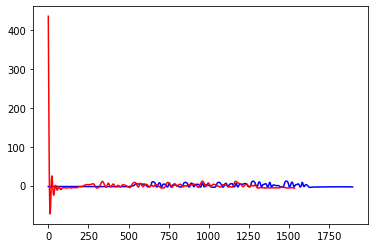

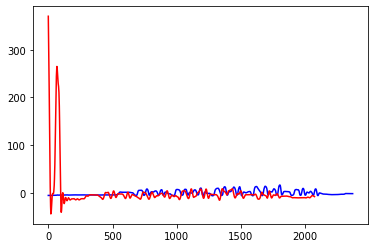

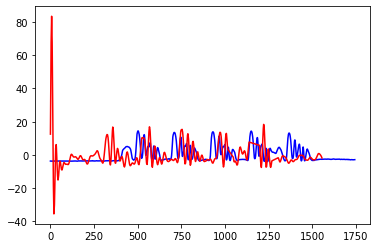

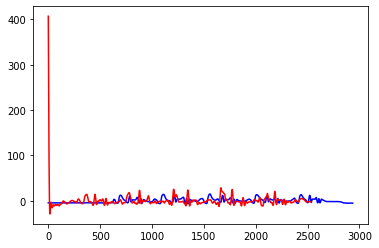

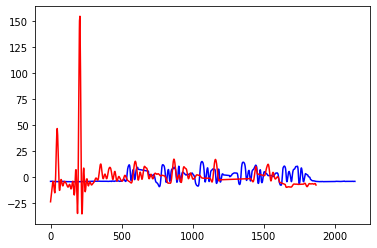

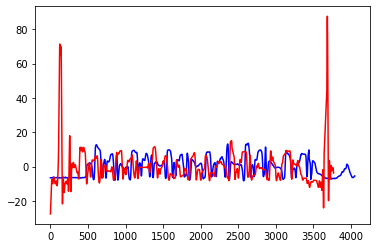

In [17]:
for i in range(len(TASK_DFS_WAVE_100HZ_LIST)):
    for j in range(len(TASK_DFS_VIDEO_100HZ_LIST)):
     
        if TASK_DFS_WAVE_100HZ_LIST[i]['PatientID'][1]== TASK_DFS_VIDEO_100HZ_LIST[j]['PatientID'][1]:
            
            if TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]== TASK_DFS_VIDEO_100HZ_LIST[j]['FileName'][1]:
  
                print(TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1])
            

                video_n = sig_norm(TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion'])
                wave_n = sig_norm(TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'])
                time = TASK_DFS_WAVE_100HZ_LIST[i]['Time'].values
                if len(video_n)<=len(wave_n):
                    upper_bound = len(video_n) 
                else: 
                    upper_bound = len(wave_n) 

                plt.figure()
                plt.plot(wave_n,'b')
                plt.plot(video_n,'r')
               # plt.plot(video_n[230:upper_bound],'r')
                #plt.plot(wave_n[400:upper_bound],'b')
                #plt.plot(video_n[400:upper_bound],'r')

BBP_NORMAL
Wave index:0
Video index:0
The phase shift is:498.18
The corrolation r and p-value between the signals are: r0.8852183107572769, p0.0

BBP_SLOW
Wave index:1
Video index:1
The phase shift is:439.93
The corrolation r and p-value between the signals are: r0.8548727703186252, p0.0

BBP_NORMAL
Wave index:2
Video index:2
The phase shift is:359.33
The corrolation r and p-value between the signals are: r0.788049664527495, p2.7298222073179333e-247

BBP_SLOW
Wave index:3
Video index:3
The phase shift is:516.37
The corrolation r and p-value between the signals are: r0.8256023159346444, p0.0

BBP_NORMAL
Wave index:4
Video index:4
The phase shift is:597.78
The corrolation r and p-value between the signals are: r0.7500288496312064, p6.376006105849341e-228

BBP_SLOW
Wave index:5
Video index:5
The phase shift is:384.66
The corrolation r and p-value between the signals are: r0.8553546645834644, p0.0



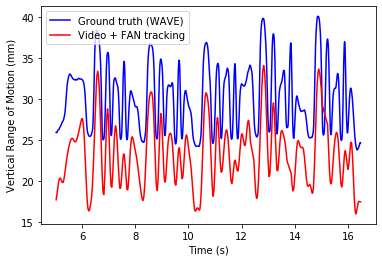

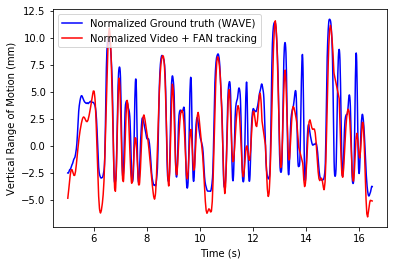

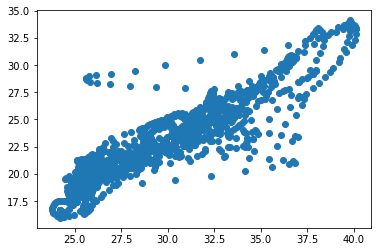

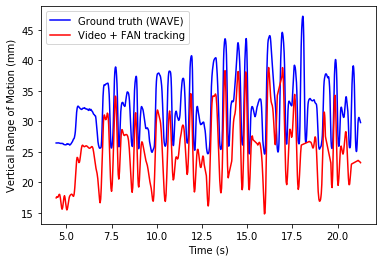

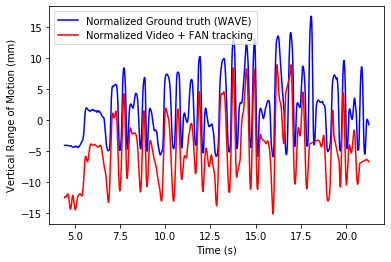

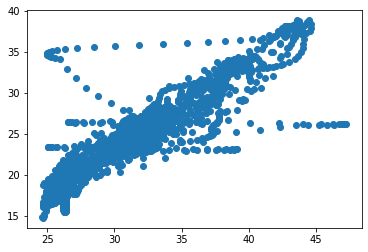

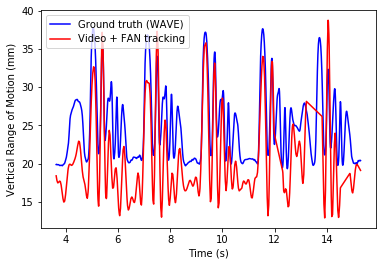

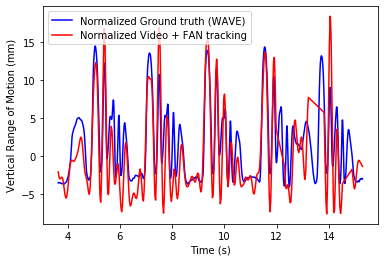

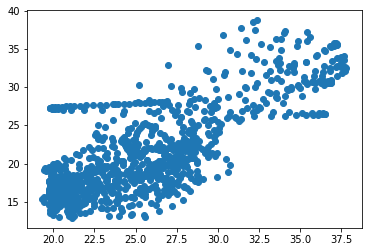

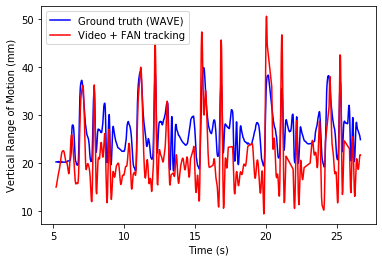

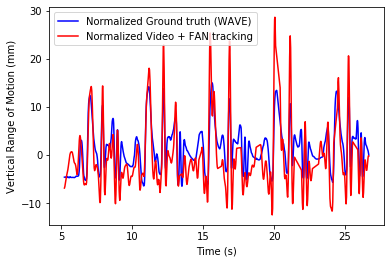

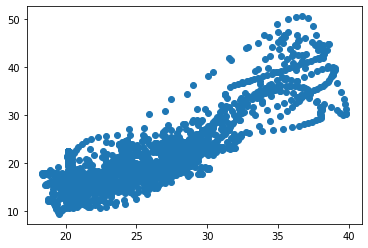

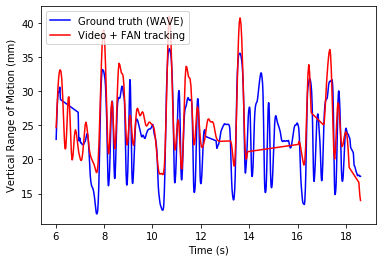

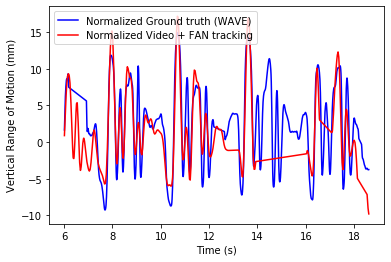

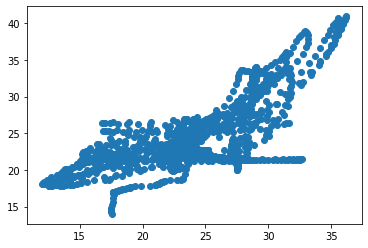

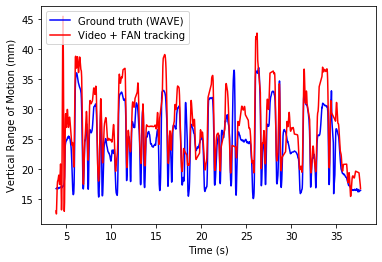

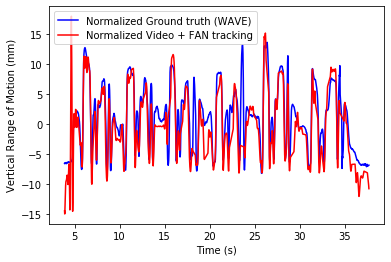

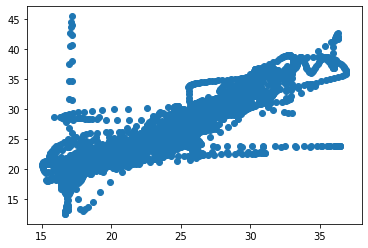

In [18]:
for i in range(len(TASK_DFS_WAVE_100HZ_LIST)):
    for j in range(len(TASK_DFS_VIDEO_100HZ_LIST)):
     
        if TASK_DFS_WAVE_100HZ_LIST[i]['PatientID'][1]== TASK_DFS_VIDEO_100HZ_LIST[j]['PatientID'][1]:
            
            if TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]== TASK_DFS_VIDEO_100HZ_LIST[j]['FileName'][1]:
  
                print(TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1])
                print('Wave index:{}'.format(i))
                print('Video index:{}'.format(j))

                result = pd.DataFrame() 

                video_n = sig_norm(TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion'])
                if TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]== "BBP_NORMAL" and TASK_DFS_WAVE_100HZ_LIST[i]['PatientID'][1]== 'RM':
                    video_n = video_n [400:-200]
                    video_shifted = TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion'] [400:-200]
                    video_speed_shifted = TASK_DFS_VIDEO_100HZ_LIST[j]['Speed'][400:-200]
                else:
                    video_n = video_n [180:-200]
                    video_shifted = TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion']  [180:-200]
                    video_speed_shifted = TASK_DFS_VIDEO_100HZ_LIST[j]['Speed'] [180:-200]
                wave_n = sig_norm(TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'])
                
                time = TASK_DFS_WAVE_100HZ_LIST[i]['Time'].values
                time_w = TASK_DFS_WAVE_100HZ_LIST[i]['Time'].values
                time_v = TASK_DFS_WAVE_100HZ_LIST[i]['Time'].values
                
                if len(video_n)<=len(wave_n):
                    upper_bound = len(video_n) 
                else: 
                    upper_bound = len(wave_n) 

                s = phase_align(wave_n, video_n, [5,upper_bound])
                sp = math.ceil(s) 

#               s = phase_align(wave_n, video_n, [5,upper_bound])
                print('The phase shift is:{}'.format(s))

#               sp = math.ceil(s)
                #ignal_bound = len(video_n) + sp
                
                
                video_shifted = sig_shift(video_shifted,sp)
               #video_shifted = sig_shift(TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion'],sp)
                video_n_s = sig_shift( video_n,sp)
                
                video_speed_shifted = sig_shift(video_speed_shifted,sp)
              #video_speed_shifted = sig_shift(TASK_DFS_VIDEO_100HZ_LIST[j]['Speed'],sp)
                
                wave_shifted = TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'].values
                wave_speed_shifted = TASK_DFS_WAVE_100HZ_LIST[i]['Speed'].values
                
                upper_bound_shifted = upper_bound + sp -1
                
                if len(wave_shifted)< upper_bound_shifted:
                    upper_bound_shifted = len(wave_shifted)
             
                name = TASK_DFS_WAVE_100HZ_LIST[i]['PatientID'][1] + '_' + TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]
                
                range_l = sp
                range_u = upper_bound_shifted-10
                
               #result['Time'] = time[range_l:range_u]
                result['Time_WAVE'] = time_w[range_l:range_u]
                result['Time_VIDEO'] = time_v[range_l:range_u]
                result['VerDisp_WAVE'] = wave_shifted[range_l:range_u]
                result['VerDisp_VIDEO'] = video_shifted[range_l:range_u]
                
                result['Speed_WAVE'] = wave_speed_shifted[range_l:range_u]
                result['Speed_VIDEO'] = video_speed_shifted[range_l:range_u]
                
                result['FileName'] = TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]
                result['PatientID'] = TASK_DFS_WAVE_100HZ_LIST[i]['PatientID'][1]
                cvs = 'final_paper_data/BBP_'+ name +'.csv'
                result.to_csv(cvs)
                Final_DFS_LIST.append(result)
                
                
               
                
                plt.figure()
                
                plt.plot(time[range_l:range_u], wave_shifted[range_l:range_u],'b', label='Ground truth (WAVE)')
                plt.plot(time[range_l:range_u],video_shifted[range_l:range_u],'r', label='Video + FAN tracking')
                plt.legend(loc="upper left")
                plt.xlabel('Time (s)')
                plt.ylabel('Vertical Range of Motion (mm)')
                
                plt.savefig('{}'.format(name))
                
                
                plt.figure()
                
                plt.plot(time[range_l:range_u],wave_n[range_l:range_u],'b', label='Normalized Ground truth (WAVE)')
                plt.plot(time[range_l:range_u],video_n_s[range_l:range_u],'r', label='Normalized Video + FAN tracking')
                plt.legend(loc="upper left")
                plt.xlabel('Time (s)')
                plt.ylabel('Vertical Range of Motion (mm)')
                plt.savefig('{}'.format(name+'Normalized'))


             
                plt.figure()
                plt.scatter(wave_shifted[range_l:range_u], video_shifted[range_l:range_u]) 
                
                
                r, p = stats.pearsonr(video_n_s[range_l:range_u], wave_n[range_l:range_u])
                print('The corrolation r and p-value between the signals are: r{}, p{}'.format(r,p))
                print()
                rms = np.sqrt(np.mean((wave_n[range_l:range_u]-video_n_s[range_l:range_u])**2))
                
                if TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1] == "BBP_SLOW":
                    bs_pc.append(r)
                    bs_rms_list.append(rms)
                elif TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1] == "BBP_NORMAL":
                    bn_pc.append(r)
                    bn_rms_list.append(rms)
                    
           
              

# START HERE

In [570]:
# DO NOT RUN MORE THAN ONCE
parsed_df_2 = pd.DataFrame(columns=['PatientID','FileName','REP','ROM_VIDEO','ROM_WAVE', 'SpdAvg_WAVE', 
                                  'SpdAvg_VIDEO','Disp_WAVE', 'Disp_VIDEO','Time_WAVE', 'Time_VIDEO',
                                  'Speed_WAVE', 'Speed_VIDEO'])


reps = ['R1', 'R2', 'R3', 'R4', 'R5']
len(Final_DFS_LIST)

6

In [729]:
reps = ['R1', 'R2', 'R3', 'R4', 'R5']
#reps = ['R1', 'R2', 'R3']

In [572]:
def apnd_adj (d, v, t, i):
    d[i] = d[i].append(d[i+1])
    v[i] = v[i].append(v[i+1])
    t[i] = t[i].append(t[i+1])
    d.pop(i+1)
    v.pop(i+1)
    t.pop(i+1)
    return d, v, t
    
    

In [688]:
# df at hand 
DF = Final_DFS_LIST[5]

In [689]:
print(len(DF['VerDisp_WAVE']))
print(len(DF['VerDisp_VIDEO']))

3379
3379


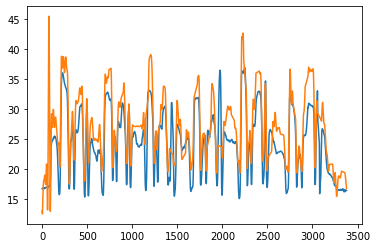

In [690]:
plt.plot(DF['VerDisp_WAVE'])
plt.plot(DF['VerDisp_VIDEO'])

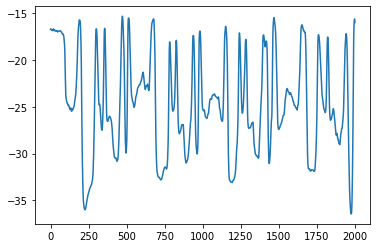

In [691]:
plt.plot(-DF['VerDisp_WAVE'][:2000])
#plt.plot(DF['VerDisp_VIDEO'])

In [699]:
peaks, _ = signal.find_peaks(-DF['VerDisp_WAVE'], height= -18, distance= 80)
print(peaks)

[   2  190  355  472  677  826  981 1150 1240 1467 1651 1760 1997 2187
 2277 2497 2711 2882 3080 3268 3351]


In [700]:
reps_w = np.array_split(DF['VerDisp_WAVE'], peaks)
reps_w_v = np.array_split(DF['Speed_WAVE'], peaks)
reps_w_t = np.array_split(DF['Time_WAVE'], peaks)
reps_v = np.array_split(DF['VerDisp_VIDEO'], peaks)
reps_v_v = np.array_split(DF['Speed_VIDEO'], peaks)
reps_v_t = np.array_split(DF['Time_VIDEO'], peaks)
if 0:
    reps_v.pop(0)
    reps_v_v.pop(0)
    reps_v_t.pop(0)
    reps_v.pop(-1)
    reps_v_v.pop(-1)
    reps_v_t.pop(-1)

    reps_w.pop(0)
    reps_w_v.pop(0)
    reps_w_t.pop(0)
    reps_w.pop(-1)
    reps_w_v.pop(-1)
    reps_w_t.pop(-1)

print(len(reps_w))

22


In [704]:
if 0: 
    reps_w.pop(2)
    reps_w_v.pop(2)
    reps_w_t.pop(2)

    reps_v.pop(2)
    reps_v_v.pop(2)
    reps_v_t.pop(2)
    print(len(reps_v), len(reps_w))


if 1: 
    reps_w.pop(-1)
    reps_w_v.pop(-1)
    reps_w_t.pop(-1)
 
    reps_v.pop(-1)
    reps_v_v.pop(-1)
    reps_v_t.pop(-1)
    print(len(reps_v), len(reps_w))
    
if 1: 
    reps_w.pop(0)
    reps_w_v.pop(0)
    reps_w_t.pop(0)
 
    reps_v.pop(0)
    reps_v_v.pop(0)
    reps_v_t.pop(0)
    print(len(reps_v),len(reps_w))
    

19 19
18 18


6 6


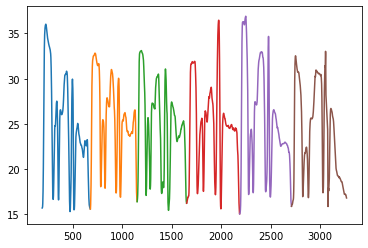

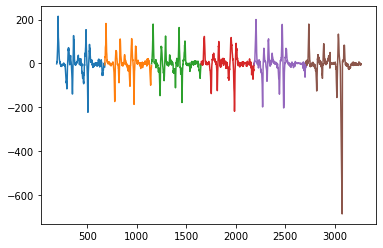

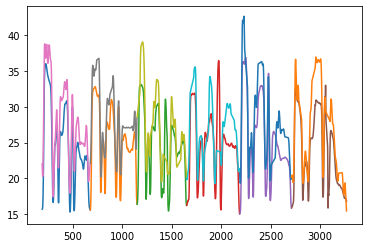

In [723]:
plt.figure()
for i in reps_w:
    plt.plot(i)

plt.figure()
for i in reps_w_v:   
    plt.plot(i)
    
if 0:
    plt.figure()
    for i in reps_v:
        plt.plot(i)
    

plt.figure()
for i in reps_w:
    plt.plot(i)
for i in reps_v:
    plt.plot(i)
print(len(reps_v),len(reps_w))

In [722]:
### CAUTION
reps_w, reps_w_v, reps_w_t = apnd_adj(reps_w, reps_w_v, reps_w_t, 5)
reps_v, reps_v_v, reps_v_t = apnd_adj(reps_v, reps_v_v, reps_v_t, 5)



In [725]:
# ROM and AVG speed analysis 
rom_w = rom(reps_w)
rom_v = rom(reps_v)
ave_s_w = np.array([np.mean(abs(rep_v)) for rep_v in reps_w_v])
ave_s_v = np.array([np.mean(abs(rep_v)) for rep_v in reps_v_v])
print(rom_w)
print(rom_v)
print(ave_s_w)
print(ave_s_v)

[20.72719912 17.2509366  17.674454   21.40899402 21.86756111 17.16562678]
[21.36181158 16.57086598 19.52831418 16.296297   23.33135256 21.52591162]
[30.1702031  27.24589458 27.28704024 26.16692846 27.94742459 33.40232732]
[30.66603268 23.47029868 24.3988017  34.27900783 37.12555621 35.20724716]


In [726]:
current_df = pd.DataFrame()

current_df['REP'] = reps
current_df['PatientID'] =  DF['PatientID'][1]
current_df['FileName'] = DF['FileName'][1]  
current_df['ROM_WAVE'] = rom_w
current_df['ROM_VIDEO'] = rom_v
current_df['SpdAvg_WAVE'] = ave_s_w
current_df['SpdAvg_VIDEO'] = ave_s_v
current_df['Disp_WAVE'] = reps_w  
current_df['Time_WAVE'] = reps_w_t  
current_df['Time_VIDEO'] = reps_v_t
current_df['Disp_VIDEO'] = reps_v
current_df['Speed_WAVE'] = reps_w_v 
current_df['Speed_VIDEO'] = reps_v_v

current_df.head()

,REP,PatientID,FileName,ROM_WAVE,ROM_VIDEO,SpdAvg_WAVE,SpdAvg_VIDEO,Disp_WAVE,Time_WAVE,Time_VIDEO,Disp_VIDEO,Speed_WAVE,Speed_VIDEO
0,R1,RM,BBP_SLOW,20.727199,21.361812,30.170203,30.666033,190 15.695398 191 15.717405 192 15.74...,190 5.788227 191 5.798231 192 5.80...,190 5.788227 191 5.798231 192 5.80...,190 22.033918 191 21.556965 192 21.08...,190 -1.947896 191 2.993039 192 8.37...,190 -46.694383 191 -45.737941 192 -44.78...
1,R2,RM,BBP_SLOW,17.250937,16.570866,27.245895,23.470299,677 15.575305 678 15.609676 679 15...,677 10.660283 678 10.670287 679 10...,677 10.660283 678 10.670287 679 10...,677 22.160263 678 22.356678 679 22...,677 -6.546971 678 22.999245 679 30...,677 36.766963 678 26.804532 679 16...
2,R3,RM,BBP_SLOW,17.674454,19.528314,27.287040,24.398802,1150 16.384293 1151 16.424238 1152 16...,1150 15.392280 1151 15.402284 1152 15...,1150 15.392280 1151 15.402284 1152 15...,1150 28.592818 1151 28.713446 1152 28...,1150 -1.131320 1151 10.053451 1152 14...,1150 12.812551 1151 15.022469 1152 17...
3,R4,RM,BBP_SLOW,21.408994,16.296297,26.166928,34.279008,1651 16.224620 1652 16.235514 1653 16...,1651 20.404394 1652 20.414399 1653 20...,1651 20.404394 1652 20.414399 1653 20...,1651 19.885866 1652 19.811117 1653 19...,1651 -3.648908 1652 0.887452 1653 7...,1651 -2.057705e+01 1652 -8.937618e+00 1653...
4,R5,RM,BBP_SLOW,21.867561,23.331353,27.947425,37.125556,2187 15.039069 2188 15.041612 2189 15...,2187 25.766657 2188 25.776661 2189 25...,2187 25.766657 2188 25.776661 2189 25...,2187 20.777083 2188 20.499516 2189 20...,2187 -6.521149 2188 2.336882 2189 1...,2187 -1.098748e-07 2188 -2.080966e-07 2189...


In [727]:
parsed_df_2 = parsed_df_2.append(current_df,ignore_index=True)

print(len(parsed_df_2))

29


In [768]:
# MAKE SURE TO CHANGE THIS!!!!!!!!!

cvs = 'BBP_PARSED_ANALYSIS_2.csv'
parsed_df_2.to_csv(cvs)
print(len(parsed_df_2))
print('DONE!')

29
DONE!


In [766]:
for i in range(len(parsed_df_2)):
    rep_df = pd.DataFrame()
    
    rep_df['Disp_VIDEO'] = parsed_df_2['Disp_VIDEO'][i]
    rep_df['Speed_VIDEO'] = parsed_df_2['Speed_VIDEO'][i]
    rep_df['Time_VIDEO'] = parsed_df_2['Time_VIDEO'][i]
    
    
    rep_df['PatientID'] =  parsed_df_2['PatientID'][i]
    rep_df['FileName'] = parsed_df_2['FileName'][i]  

    rep_df['ROM_VIDEO'] = parsed_df_2['ROM_VIDEO'] [i]

    rep_df['SpdAvg_VIDEO'] = parsed_df_2 ['SpdAvg_VIDEO'][i]
    name = parsed_df_2['PatientID'][i] + '_' + parsed_df_2['FileName'][i] + '_VIDEO_' +parsed_df_2['REP'][i] 

    cvs = 'Parsed_Data2/BBP_'+ name +'.csv'
    rep_df.to_csv(cvs)

In [767]:
for i in range(len(parsed_df_2)):
    rep_df = pd.DataFrame()
    
    rep_df['Disp_WAVE'] = parsed_df_2['Disp_WAVE'][i]
    rep_df['Speed_WAVE'] = parsed_df_2['Speed_WAVE'][i]
    rep_df['Time_WAVE'] = parsed_df_2['Time_WAVE'][i]
    
    rep_df['PatientID'] =  parsed_df_2['PatientID'][i]
    rep_df['FileName'] = parsed_df_2['FileName'][i]  

    rep_df['ROM_WAVE'] = parsed_df_2['ROM_WAVE'] [i]

    rep_df['SpdAvg_WAVE'] = parsed_df_2 ['SpdAvg_WAVE'][i]
    name = parsed_df_2['PatientID'][i] + '_' + parsed_df_2['FileName'][i] + '_WAVE_' +parsed_df_2['REP'][i] 

    cvs = 'Parsed_Data2/BBP_'+ name +'.csv'
    rep_df.to_csv(cvs)

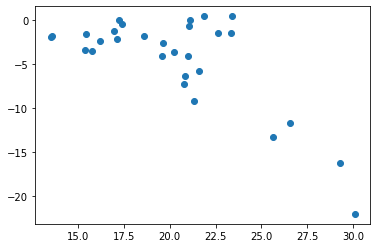

In [505]:
parsed_df['ROM_AVG'] = np.mean([parsed_df['ROM_WAVE'],parsed_df['ROM_VIDEO']], axis=0)
parsed_df['ROM_Diff'] = parsed_df['ROM_WAVE'] - parsed_df['ROM_VIDEO']
    #plt.figure()
    
colors = {0: 'red', 1: 'aqua', 2: 'blue'}
plt.plot(parsed_df['ROM_AVG'], parsed_df['ROM_Diff'], 'o')
    

In [748]:
deniz = parsed_df_2.loc[lambda DF: parsed_df_2['PatientID'] == 'DJ']
mk = parsed_df_2.loc[lambda DF: parsed_df_2['PatientID'] == 'MK']
rm = parsed_df_2.loc[lambda DF: parsed_df_2['PatientID'] == 'RM']


#stats.pearsonr(deniz['ROM_WAVE'].values, deniz['ROM_VIDEO'].values)



In [761]:
print(stats.spearmanr(deniz['ROM_WAVE'].values, deniz['ROM_VIDEO'].values))
print(stats.spearmanr(deniz['SpdAvg_WAVE'].values, deniz['SpdAvg_VIDEO'].values))
print()
#print(stats.pearsonr(mk['ROM_WAVE'].values, mk['ROM_Video'].values))
print(stats.spearmanr(mk['ROM_WAVE'].values, mk['ROM_VIDEO'].values))
print(stats.spearmanr(mk['SpdAvg_WAVE'].values, mk['SpdAvg_VIDEO'].values))
#print(stats.spearmanr(sig_norm(mk['ROM_WAVE'].values), sig_norm(mk['ROM_VIDEO'].values)))
#
print()
#print(stats.pearsonr(rm['ROM_WAVE'].values, rm['ROM_Video'].values))
print(stats.spearmanr(rm['ROM_WAVE'].values, rm['ROM_VIDEO'].values))
print(stats.spearmanr(rm['SpdAvg_WAVE'].values, rm['SpdAvg_VIDEO'].values))
#print(stats.spearmanr(sig_norm(rm['ROM_WAVE'].values), sig_norm(rm['ROM_VIDEO'].values)))
print()

print(stats.spearmanr(parsed_df_2['ROM_WAVE'].values, parsed_df_2['ROM_VIDEO'].values))
print(stats.spearmanr(parsed_df_2['SpdAvg_WAVE'].values, parsed_df_2['SpdAvg_VIDEO'].values))
print()


SpearmanrResult(correlation=0.9151515151515152, pvalue=0.0002044724061488323)
SpearmanrResult(correlation=0.5515151515151515, pvalue=0.09840117666963498)

SpearmanrResult(correlation=0.6727272727272726, pvalue=0.0330412225454377)
SpearmanrResult(correlation=0.6848484848484848, pvalue=0.02888279750673276)

SpearmanrResult(correlation=0.3666666666666667, pvalue=0.33173980143301507)
SpearmanrResult(correlation=0.7666666666666667, pvalue=0.01594401657897401)

SpearmanrResult(correlation=0.5724137931034481, pvalue=0.0011754202546248255)
SpearmanrResult(correlation=0.5438423645320195, pvalue=0.002293053671946863)



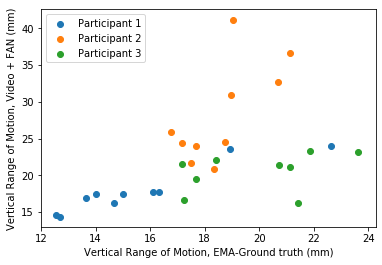

In [770]:
plt.figure()
plt.scatter(deniz['ROM_WAVE'].values, deniz['ROM_VIDEO'].values, label='Participant 1' )


plt.scatter(mk['ROM_WAVE'].values, mk['ROM_VIDEO'].values, label='Participant 2')

plt.scatter(rm['ROM_WAVE'].values, rm['ROM_VIDEO'].values, label='Participant 3')



plt.legend(loc="upper left")
plt.xlabel('Vertical Range of Motion, EMA-Ground truth (mm)')
plt.ylabel('Vertical Range of Motion, Video + FAN (mm)')
plt.savefig('{}'.format('BBP_REP_CORR'))

In [765]:
print(mk['ROM_WAVE'].values)
print(mk['ROM_VIDEO'].values)

[17.68091134 17.15722012 17.51326346 18.35452123 16.75191277 18.74482556
 20.69645111 21.11891512 19.05353319 18.95623156]
[24.04354585 24.36893273 21.64024426 20.90061013 25.92401915 24.50151492
 32.66442167 36.65141017 41.10994098 30.96639836]


BBP_NORMAL_R1
BBP_NORMAL_R2
BBP_NORMAL_R3
BBP_SLOW_R1
BBP_SLOW_R2
BBP_SLOW_R3
BBP_SLOW_R4
BBP_SLOW_R5
BBP_SLOW_R6


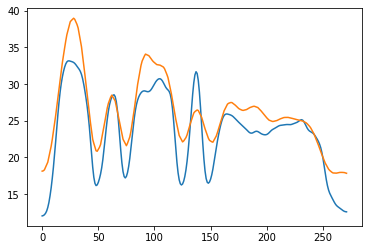

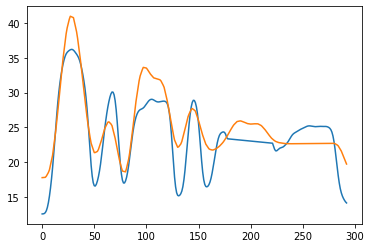

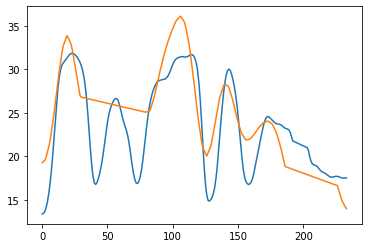

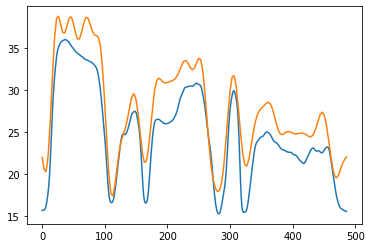

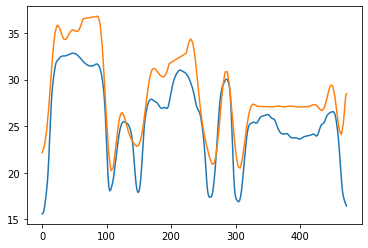

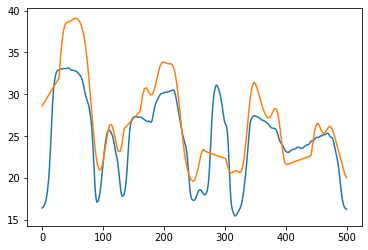

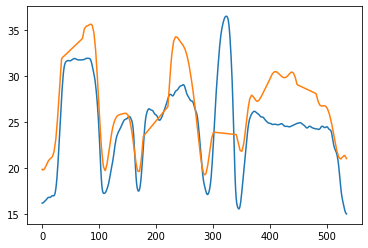

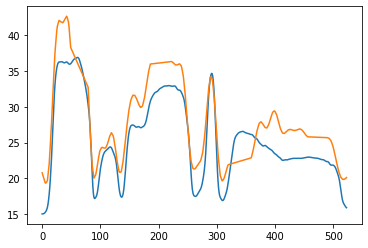

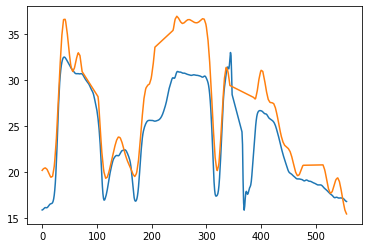

In [746]:
for i in range(len(rm)):
    i = i +20
    print(rm['FileName'][i] + '_' + rm['REP'][i] )
    plt.figure()
    
    plt.plot(rm['Disp_WAVE'][i].values)
    plt.plot(rm['Disp_VIDEO'][i].values)
            

BBP_NORMAL_R1
BBP_NORMAL_R2
BBP_NORMAL_R3
BBP_NORMAL_R4
BBP_NORMAL_R5
BBP_SLOW_R1
BBP_SLOW_R2
BBP_SLOW_R3
BBP_SLOW_R4
BBP_SLOW_R5


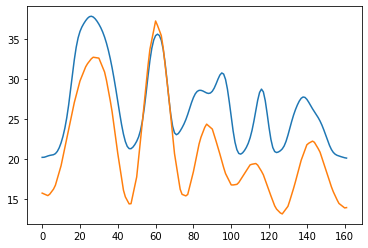

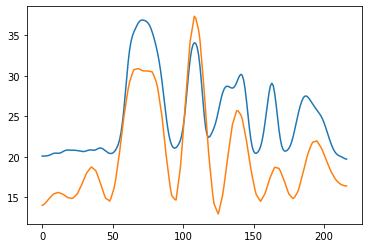

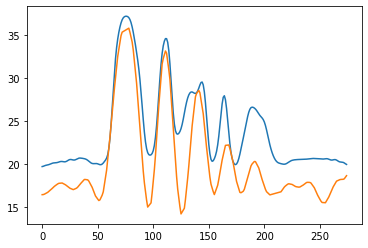

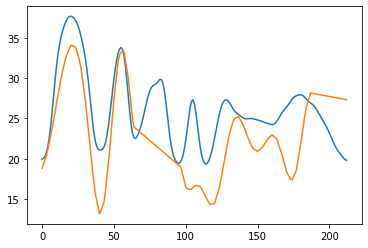

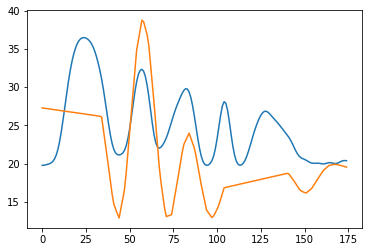

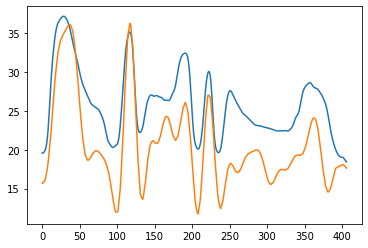

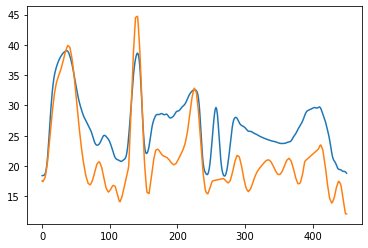

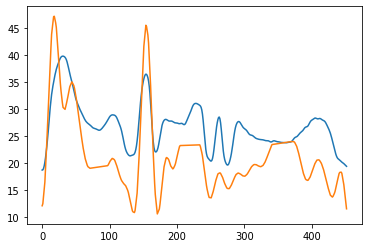

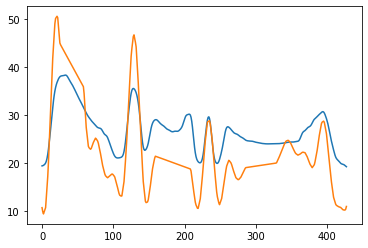

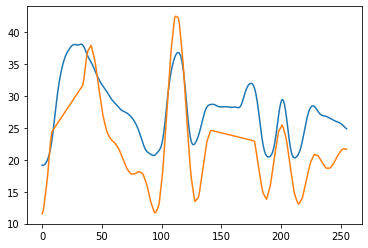

In [757]:
for i in range(len(mk)):
    i = i +10
    print(mk['FileName'][i] + '_' + mk['REP'][i] )
    plt.figure()
    
    plt.plot(mk['Disp_WAVE'][i].values)
    plt.plot(mk['Disp_VIDEO'][i].values)

BBP_NORMAL_R1
BBP_NORMAL_R2
BBP_NORMAL_R3
BBP_NORMAL_R4
BBP_NORMAL_R5
BBP_SLOW_R1
BBP_SLOW_R2
BBP_SLOW_R3
BBP_SLOW_R4
BBP_SLOW_R5


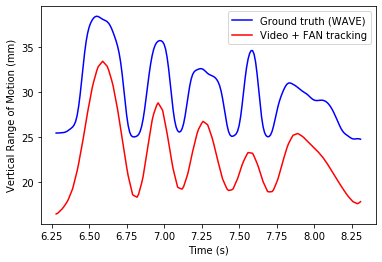

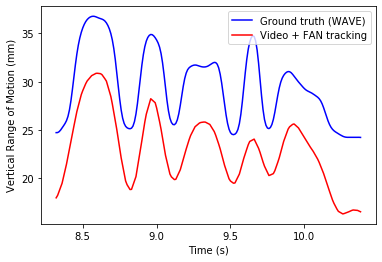

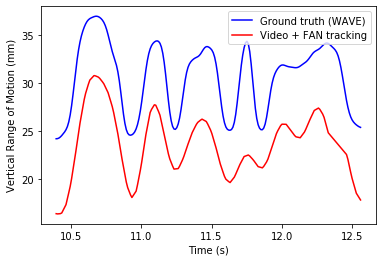

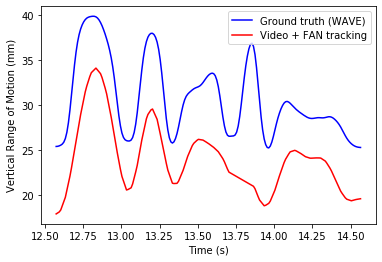

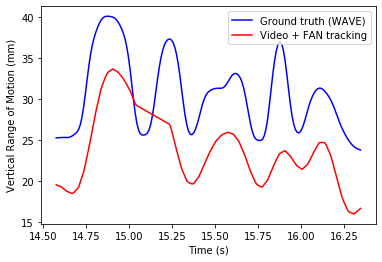

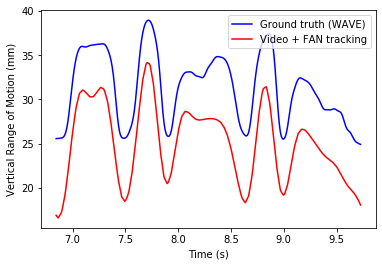

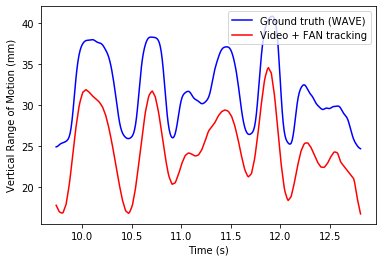

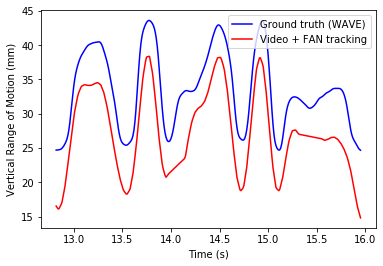

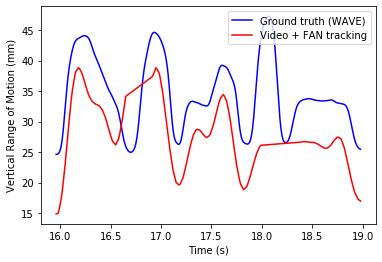

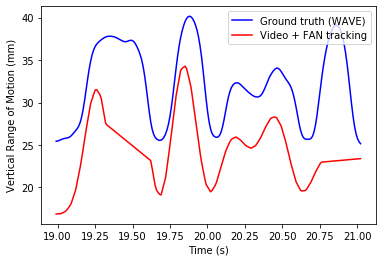

In [774]:
for i in range(len(deniz)):

    print(deniz['FileName'][i] + '_' + deniz['REP'][i] )
    plt.figure()
    
    plt.plot(deniz['Time_WAVE'][i].values, deniz['Disp_WAVE'][i].values, 'b', label='Ground truth (WAVE)')
    plt.plot( deniz['Time_VIDEO'][i].values,deniz['Disp_VIDEO'][i].values, 'r', label='Video + FAN tracking')
    
    plt.legend(loc="upper right")
    plt.xlabel('Time (s)')
    plt.ylabel('Vertical Range of Motion (mm)')
    plt.savefig('{}'.format('BBP_REP_' + deniz['REP'][i]))

In [ ]:
print(bn_pc)
print(bs_pc)

import statistics 
from statistics import mean 
from statistics import stdev 
print(mean(bn_pc))
print(mean(bs_pc))

print()
print(stdev(bn_pc))
print(stdev(bs_pc))


print(mean(bn_rms_list),stdev(bn_rms_list))
print(mean(bs_rms_list),stdev(bs_rms_list))


In [ ]:
sn_v_pc = list()
sh_v_pc = list()

sn_v_v = list()
sh_v_v = list()
sn_v_w = list()
sh_v_w = list()

sh_v_std_v = list()
sh_v_std_w = list()

sn_v_std_v = list()
sn_v_std_w = list()

In [ ]:
for i in range(len(Final_DFS_LIST)):
    plt.figure()
    plt.plot(Final_DFS_LIST[i]['Time'], Final_DFS_LIST[i]['Speed_WAVE'],
             'b',label='Ground truth (WAVE)')
    plt.plot(Final_DFS_LIST[i]['Time'],Final_DFS_LIST[i]['Speed_VIDEO'],
             'r', label='Video + FAN tracking')
    plt.legend(loc="upper left")
    plt.xlabel('Time (s)')
    plt.ylabel('Vertical Range of Motion Velocity(mm/s)')
    plt.savefig('{}'.format('BBP_'+Final_DFS_LIST[i]['FileName'][1]+'Velocity'))
    r, p = stats.pearsonr(Final_DFS_LIST[i]['Speed_WAVE'], 
                          Final_DFS_LIST[i]['Speed_VIDEO'])
    
    
    ave_s_w = np.mean(abs(Final_DFS_LIST[i]['Speed_WAVE']))
    ave_s_v = np.mean(abs(Final_DFS_LIST[i]['Speed_VIDEO']))
    
    std_s_w = np.std(abs(Final_DFS_LIST[i]['Speed_WAVE']))
    std_s_v = np.std(abs(Final_DFS_LIST[i]['Speed_VIDEO']))
    
    if Final_DFS_LIST[i]['FileName'][1] == "BBP_SLOW":
        sh_v_pc.append(r)
        
        sh_v_v.append(ave_s_v)
        sh_v_w.append(ave_s_w)
        
        sh_v_std_v.append(std_s_v)
        sh_v_std_w.append(std_s_w)
      

    elif Final_DFS_LIST[i]['FileName'][1] == "BBP_NORMAL":
        sn_v_pc.append(r)
        
        sn_v_v.append(ave_s_v)
        sn_v_w.append(ave_s_w)
        
        sn_v_std_v.append(std_s_v)
        sn_v_std_w.append(std_s_w)
      

In [ ]:
print(sn_v_pc)
print(sh_v_pc)
print()
print(mean(sn_v_pc), stdev(sn_v_pc))
print(mean(sh_v_pc), stdev(sh_v_pc))

print()
print(sn_v_w)
print(sn_v_v)
print()
print(sh_v_w)
print(sh_v_v)
print()
print(sn_v_std_w)
print(sn_v_std_v)
print()

print(sh_v_std_w)
print(sh_v_std_v)
print()


In [ ]:
for i in range(len(Final_DFS_LIST)):
    Final_DFS_LIST[i]['VerDisp_AVG'] = np.mean([Final_DFS_LIST[i]['VerDisp_WAVE'], Final_DFS_LIST[i]['VerDisp_VIDEO']], axis=0)
    Final_DFS_LIST[i]['VerDisp_Diff'] = Final_DFS_LIST[i]['VerDisp_WAVE'] - Final_DFS_LIST[i]['VerDisp_VIDEO']
    #plt.figure()
    plt.plot(Final_DFS_LIST[i]['VerDisp_AVG'], Final_DFS_LIST[i]['VerDisp_Diff'],'o' )
    

In [ ]:
plt.plot(Final_DFS_LIST[1]['VerDisp_WAVE'],'b' )
plt.plot(Final_DFS_LIST[1]['Speed_WAVE'],'r' )

In [ ]:
rms = [3.71, 9.00, 4.70 ,7.35, 2.59 ,2.04, 3.20, 4.88] 


In [ ]:
video_n = sig_norm(TASK_DFS_VIDEO_100HZ_LIST[4]['Vert_Lip_Motion'])
wave_n = sig_norm(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'])

upper_bound = len(video_n) - 10
upper_bound2 = len(wave_n) - 10

s = phase_align(wave_n[600:1100], video_n, [10,upper_bound])
print('The phase shift is:{}'.format(s))

sp = math.ceil(s) + 600


video_shifted = sig_shift(TASK_DFS_VIDEO_100HZ_LIST[4]['Vert_Lip_Motion'],sp)

if len(video_shifted) <= len(wave_n):
    signal_bound = upper_bound + sp
else: 
    signal_bound = len(wave_n) - 10 

print()
plt.figure()

plt.plot(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'],'b')
plt.plot(TASK_DFS_VIDEO_100HZ_LIST[4]['Vert_Lip_Motion'],'r')

plt.figure()
a = np.gradient(TASK_DFS_WAVE_100HZ_LIST[6]['Time'])
plt.plot(a, 'b')
b = np.gradient(TASK_DFS_VIDEO_100HZ_LIST[4]['Time'])
plt.plot(b, 'r')

plt.figure()
plt.plot(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'],'b')
plt.plot(video_shifted,'r')

plt.figure()
plt.scatter(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'][sp:signal_bound], 
            video_shifted[sp:signal_bound])


In [ ]:
%matplotlib qt
plt.plot(TASK_DFS_WAVE_LIST[3]['Vert_Lip_Motion'],'o')
plt.plot(TASK_DFS_WAVE_100HZ_LIST[3]['Vert_Lip_Motion'])

In [ ]:
plt.plot(TASK_DFS_WAVE_100HZ_LIST[3]['Vert_Lip_Motion'],'o')

In [ ]:

path_v = r'C:\Users\jafarid\Documents\Code\ValidationStudy\video_data_processed'
ext_v=('_Landmarks3D.csv')
Files_v = os.listdir(path_v)           
Files_v = [i for i in Files_v if i.endswith(ext_v)]

for i in range(0, len(Files_v)):
    print(Files_v[i][12:-16])
print(len(Files_w))

In [ ]:

plt.figure()

#plt.plot(TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'],'b')
#plt.plot(TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion'],'r')
plt.plot(wave_shifted,'b')
plt.plot(video_shifted,'r')
#plt.legend()
#plt.figure()
#a = np.gradient(TASK_DFS_WAVE_100HZ_LIST[i]['Time'])
#plt.plot(a, 'b')
#b = np.gradient(TASK_DFS_VIDEO_100HZ_LIST[j]['Time'])
#plt.plot(b, 'r')

plt.figure()
#lt.plot(TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'][sp:upper_bound],'b')
#plt.plot(wave_shifted[sp:upper_bound],'b')
#plt.plot(video_shifted[sp:upper_bound],'r')
plt.plot(wave_n[400:upper_bound],'b')
plt.plot(video_n_s[400:upper_bound],'r')
#plt.legend()

plt.figure()

plt.scatter(wave_shifted[400: upper_bound], video_shifted[400:upper_bound])

r, p = stats.pearsonr(video_n_s[200:upper_bound], 
                      wave_n[200:upper_bound])
print('The corrolation r and p-value between the signals are: r{}, p{}'.format(r,p))
print()

